# NeqSim in jupyter

NeqSim can be run from jupyter by using the py4j python package. The JavaGateway must be started before the program can be run. Initially we connect to Java and import numpy and matplotlib for plotting.

In [1]:
import neqsim
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from neqsim.thermo import *
import pandas as pd

##Example 1 Setting up a thermodynamic calculation using NeqSim

In [2]:
thermoSystem = jneqsim.thermo.system.SystemSrkEos(280.0, 10.0)
thermoSystem.addComponent("methane", 10.0)
thermoSystem.addComponent("water", 4.0)

thermoOps = jneqsim.thermodynamicoperations.ThermodynamicOperations(thermoSystem)
thermoOps.TPflash()

# thermoSystem.display()

gasEnthalpy = thermoSystem.getPhase(0).getEnthalpy()

thermoSystem.initPhysicalProperties("Viscosity")
gasViscosity = thermoSystem.getPhase(0).getViscosity("kg/msec")

print("Gas enthalpy ", gasEnthalpy)
print("Gas viscosity ", gasViscosity)

Gas enthalpy  1079.8561270889081
Gas viscosity  1.0760998263782569e-05


##Example 2 Calculation of a phase envelope using NeqSim

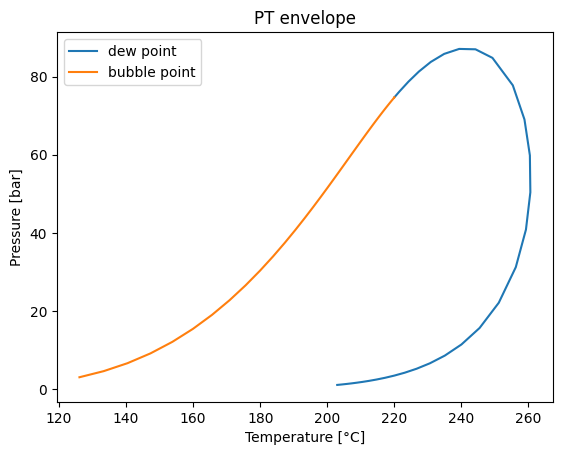

In [3]:
thermoSystem = jneqsim.thermo.system.SystemSrkEos(280.0, 10.0)
thermoSystem.addComponent("nitrogen", 1.0)
thermoSystem.addComponent("methane", 70.0)
thermoSystem.addComponent("ethane", 4.0)
thermoSystem.addComponent("propane", 2.0)
thermoSystem.addComponent("i-butane", 1.0)
thermoSystem.addComponent("n-butane", 1.0)

thermoOps = jneqsim.thermodynamicoperations.ThermodynamicOperations(thermoSystem)
thermoOps.calcPTphaseEnvelope()

plt.plot(
    list(thermoOps.getOperation().get("dewT")),
    list(thermoOps.getOperation().get("dewP")),
    label="dew point",
)
plt.plot(
    list(thermoOps.getOperation().get("bubT")),
    list(thermoOps.getOperation().get("bubP")),
    label="bubble point",
)
plt.title("PT envelope")
plt.xlabel("Temperature [\u00B0C]")
plt.ylabel("Pressure [bar]")
plt.legend()
plt.show()

##Example 3 Calculation of hydrate equilibrium temperature using NeqSim

In [4]:
thermoSystem = jneqsim.thermo.system.SystemSrkEos(280.0, 60.0)
thermoSystem.addComponent("methane", 90.0)
thermoSystem.addComponent("ethane", 10.0)
thermoSystem.addComponent("propane", 1.0)
thermoSystem.addComponent("water", 4.0)
thermoSystem.setHydrateCheck(True)
thermoOps = jneqsim.thermodynamicoperations.ThermodynamicOperations(thermoSystem)
thermoOps.hydrateFormationTemperature()

print("Hydrate equilibrium temperature ", thermoSystem.getTemperature() - 273.15, " C")

Hydrate equilibrium temperature  15.407359934325314  C


##Example 4 Oil characterization

gas density  74.1410489655628
oil density  713.5448551807647


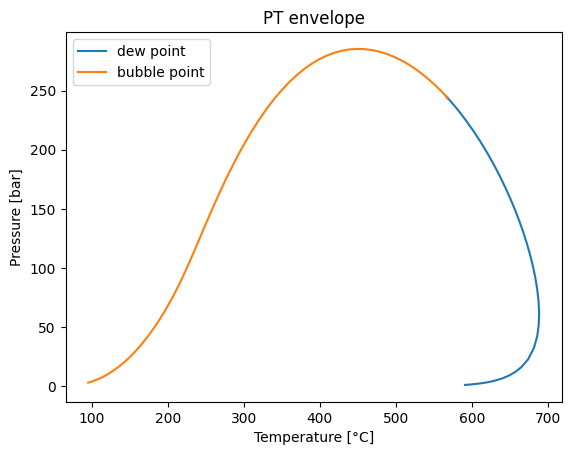

In [5]:
thermoSystem = jneqsim.thermo.system.SystemSrkEos(280.0, 60.0)
thermoSystem.addComponent("nitrogen", 2.0)
thermoSystem.addComponent("CO2", 1.0)
thermoSystem.addComponent("methane", 10.0)
thermoSystem.addComponent("ethane", 10.0)
thermoSystem.addComponent("propane", 1.0)
thermoSystem.addTBPfraction("C6", 0.428, 86.178 / 1000.0, 0.664)
thermoSystem.addTBPfraction("C7", 0.626, 96.00 / 1000.0, 0.738)
thermoSystem.addTBPfraction("C8", 0.609, 107.0 / 1000.0, 0.765)
thermoSystem.addTBPfraction("C9", 0.309, 121.0 / 1000.0, 0.781)
thermoSystem.addPlusFraction("C10", 5.137, 231.0 / 1000.0, 0.8301)
thermoSystem.getCharacterization().getLumpingModel().setNumberOfLumpedComponents(12)
thermoSystem.getCharacterization().characterisePlusFraction()
thermoSystem.setMixingRule(2)

thermoOps = jneqsim.thermodynamicoperations.ThermodynamicOperations(thermoSystem)
thermoOps.TPflash()

# thermoSystem.display()

thermoSystem.initPhysicalProperties("Density")
gasDensity = thermoSystem.getPhase("gas").getDensity("kg/m3")
oilDensity = thermoSystem.getPhase("oil").getDensity("kg/m3")

print("gas density ", gasDensity)
print("oil density ", oilDensity)

thermoOps = jneqsim.thermodynamicoperations.ThermodynamicOperations(thermoSystem)
thermoOps.calcPTphaseEnvelope()

plt.plot(
    list(thermoOps.getOperation().get("dewT")),
    list(thermoOps.getOperation().get("dewP")),
    label="dew point",
)
plt.plot(
    list(thermoOps.getOperation().get("bubT")),
    list(thermoOps.getOperation().get("bubP")),
    label="bubble point",
)
plt.title("PT envelope")
plt.xlabel("Temperature [\u00B0C]")
plt.ylabel("Pressure [bar]")
plt.legend()
plt.show()

##Example 5 Process simulation

In [6]:
processequipment = jneqsim.process.processequipment

testSystem = jneqsim.thermo.system.SystemSrkEos((273.15 + 50.0), 50.00)
testSystem.addComponent("methane", 900.00)
testSystem.addComponent("ethane", 200.00)
testSystem.addComponent("n-hexane", 200.0)
testSystem.addComponent("n-nonane", 200.0)
testSystem.addComponent("nC10", 20.0)
testSystem.addComponent("nC13", 10.0)
testSystem.setMixingRule(2)

stream_1 = processequipment.stream.Stream("Stream1", testSystem)

mixerHP = processequipment.mixer.StaticMixer("Mixer HP")
mixerHP.addStream(stream_1)

separator = processequipment.separator.Separator("Separator 1", mixerHP.getOutStream())

LP_valve = processequipment.valve.ThrottlingValve(
    "LPventil", separator.getLiquidOutStream()
)
LP_valve.setOutletPressure(5.0)

LPseparator = processequipment.separator.Separator(
    "Separator 1", LP_valve.getOutStream()
)

LPcompressor = processequipment.compressor.Compressor(LPseparator.getGasOutStream())
LPcompressor.setOutletPressure(50.0)

heaterLP = processequipment.heatexchanger.Heater(LPcompressor.getOutStream())
heaterLP.setOutTemperature(270.25)

stream_2 = processequipment.stream.Stream("cooled gas", heaterLP.getOutStream())

gasScrubber = processequipment.separator.GasScrubberSimple("Scrubber", stream_2)
gasScrubber.setInletStream(stream_2)

stream_3 = processequipment.stream.Stream(
    "liq from scrubber gas", gasScrubber.getLiquidOutStream()
)

mixerHP.addStream(stream_3)

mixer = processequipment.mixer.StaticMixer("Mixer export")
mixer.addStream(separator.getGasOutStream())
mixer.addStream(gasScrubber.getGasOutStream())

HPcompressor = processequipment.compressor.Compressor(mixer.getOutStream())
HPcompressor.setOutletPressure(200.0)

operations = jneqsim.process.processmodel.ProcessSystem()
operations.add(stream_1)
operations.add(mixerHP)
operations.add(separator)
operations.add(LP_valve)
operations.add(LPseparator)
operations.add(LPcompressor)
operations.add(heaterLP)
operations.add(stream_2)
operations.add(gasScrubber)
operations.add(stream_3)
operations.add(mixer)
operations.add(HPcompressor)

operations.run()

print("LP compressor power ", LPcompressor.getPower() / 1000.0, " kW")
print("HP compressor power ", HPcompressor.getPower() / 1000.0, " kW")

AttributeError: Java package 'neqsim.process' has no attribute 'processequipment'


##Example 6 Create pS and pH diagram

Text(0, 0.5, 'Entropy [kJ/kgK]')

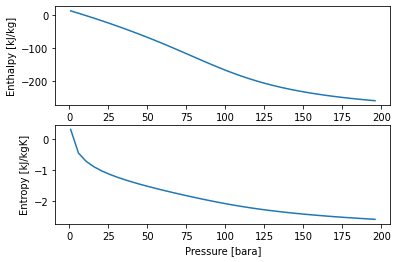

In [7]:
thermoSystem = jneqsim.thermo.system.SystemSrkEos(280.0, 10.0)
thermoSystem.addComponent("methane", 10.0)
thermoSystem.addComponent("ethane", 4.0)

thermoOps = jneqsim.thermodynamicoperations.ThermodynamicOperations(thermoSystem)
thermoOps.TPflash()


def enthalpy(P):
    thermoSystem.setPressure(P)
    thermoSystem.init(3)
    return thermoSystem.getEnthalpy("kJ/kg")


def entropy(P):
    thermoSystem.setPressure(P)
    thermoSystem.init(3)
    return thermoSystem.getEntropy("kJ/kgK")


pressure = np.arange(1.0, 200.0, 5.0)
enthalpy = [enthalpy(P) for P in pressure]
entropy = [entropy(P) for P in pressure]

plt.subplot(2, 1, 1)
plt.plot(pressure, enthalpy)
plt.xlabel("Pressure [bara]")
plt.ylabel("Enthalpy [kJ/kg]")

plt.subplot(2, 1, 2)
plt.plot(pressure, entropy)
plt.xlabel("Pressure [bara]")
plt.ylabel("Entropy [kJ/kgK]")

Example 7 Using the neqsim Python package (pip distribution neqsim)

In [10]:
from neqsim.thermo import fluid, printFrame
fluid1 = fluid("srk")
fluid1.addComponent("methane", 10.0)
fluid1.addComponent("n-heptane", 2.0)
fluid1.addComponent("water", 3.0)
fluid1.setMixingRule(2)
fluid1.setMultiPhaseCheck(True)
TPflash(fluid1)
printFrame(fluid1)

                       0           1           2            3 4 5  \
0                              total         GAS      AQUEOUS       
1                methane  6.66667E-1  8.13907E-1   5.02515E-9       
2              n-heptane  1.33333E-1  1.62781E-1  1.29701E-25       
3                  water        2E-1   2.3312E-2          1E0       
4                                                                   
5                Density               1.22577E0    1.00172E3       
6         Phase Fraction              8.19095E-1   1.80905E-1       
7             Molar Mass   2.7659E-2   2.9789E-2    1.8015E-2       
8               Z factor              9.93332E-1   7.35079E-4       
9     Heat Capacity (Cp)               1.91919E0    4.81092E0       
10    Heat Capacity (Cv)               1.63218E0    3.53037E0       
11        Speed of Sound               3.10779E2    3.45954E3       
12              Enthalpy  -2.62425E5   4.49999E4    -2.5641E6       
13               Entropy  -5.31475

In [11]:
fluid1 = fluid("srk")
fluid1.addComponent("methane", 10.0)
fluid1.addComponent("n-heptane", 2.0)
fluid1.setMixingRule(2)
TPflash(fluid1)

print("density ", fluid1.getPhase("gas").getDensity(), " kg/m3")

density  0.8659695521155993  kg/m3


In [20]:
fluid1 = fluid("srk")
fluid1.addComponent("n-heptane", 49.39)
# fluid1.addComponent('methane',50.61)
fluid1.setMixingRule(2)
fluid1.setTemperature(267.12)
fluid1.setPressure(17.91)
# fluid1.useVolumeCorrection(True)
TPflash(fluid1)
fluid1.initPhysicalProperties()

print("density ", fluid1.getPhase("oil").getDensity(), " kg/m3")
print("thermal conductivity ", fluid1.getPhase("oil").getThermalConductivity('W/mK'))
fluid1.getPhase(0).getPhysicalProperties().setConductivityModel("PFCT")
fluid1.initPhysicalProperties()
print("thermal conductivity ", fluid1.getPhase("oil").getThermalConductivity('W/mK'))

density  617.2714448481995  kg/m3
thermal conductivity  0.12321094874956391
thermal conductivity  0.12321094874956391
